# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 10.04.2023

Мягкий дедлайн: 24.04.2022 23:59 MSK

Жёсткий дедлайн: 30.04.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). 

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [1]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻
# было так страшно, что даже не начинала(((((

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [518]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans
from numpy import linalg as LA
from scipy.sparse.linalg import eigsh


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''

        # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿|
        D = np.diag(np.sum(X, axis = 1))
        L = D - X
        w, eigenvectors = eigsh(L, which='SM')
        return eigenvectors

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [519]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [520]:
data = pd.read_excel('transport.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en                                            Name_en  \
0    278    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    279    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    355    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    356    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    357    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [521]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [522]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [523]:
from scipy.spatial.distance import squareform, pdist
import networkx as nx
from itertools import combinations

def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    new = data[['ID_en', 'RouteNumbers_en']]
    new['RouteNumbers_en'] = new['RouteNumbers_en'].apply(lambda x: x.replace(' ', '').split(';'))
    new = new.set_index('ID_en')
    dict_stops = new.T.to_dict('index')['RouteNumbers_en']
    
    # источник https://stackoverflow.com/questions/35491223/inverting-a-dictionary-with-list-values
    new_dic = {}
    for k,v in dict_stops.items():
        for x in v:
            new_dic.setdefault(x,[]).append(k)
    return new_dic


def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    dict_res = {}
    for route in routes.keys():
        stops = routes[route]
        df = data[['ID_en', 'Longitude_WGS84_en', 'Latitude_WGS84_en']]
        df = df[df['ID_en'].isin(stops)]
        distances = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df['ID_en'].unique(), index=df['ID_en'].unique())
        most_dist = int(pd.DataFrame(distances.sum()).idxmax())
        
        sorted_stops = [most_dist]
        drop_stops = [most_dist]
        cur_stop = most_dist
        while len(sorted_stops) != len(stops):
            next_stop = int(pd.DataFrame(distances[cur_stop]).drop(drop_stops).idxmin())
            sorted_stops.append(next_stop)
            drop_stops.append(next_stop)
            cur_stop = next_stop
        dict_res.update({route: sorted_stops})
    return dict_res
    


def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    i = 1
    for route in sorted_routes.keys():
        stops = sorted_routes[route]
        pairs = list(zip(stops, stops[1:]))
        if i == 1:
            pairsDict = {key: 1 for key in pairs}
        else:
            for pair in pairs:
                if pair in pairsDict.keys():
                    pairsDict[pair] += 1
                elif (pair[1], pair[0]) in pairsDict.keys():
                    pair_new = (pair[1], pair[0])
                    pairsDict[pair_new] += 1
                else:
                    pairsDict[pair] = 1
        i += 1
    G = nx.Graph()
    for edge in pairsDict.keys():
        G.add_edge(edge[0], edge[1], weight=pairsDict[edge])
    adj_matrix = np.array(nx.adjacency_matrix(G).todense()).T
    return adj_matrix

In [524]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

/var/folders/g6/h54zm38s0yxgp8fzt3h3tqbc0000gn/T/ipykernel_27171/2877238104.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['RouteNumbers_en'] = new['RouteNumbers_en'].apply(lambda x: x.replace(' ', '').split(';'))


Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [530]:
data.set_index('ID_en', inplace = True)

In [531]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=163):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [77]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    
    #источник: https://www.kaggle.com/code/lucaspcarlini/clustering-and-visualisation-using-folium-maps/notebook
    
    map_clusters = folium.Map([55.75215, 37.61819], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(len(np.unique(labels)))
    ys = [i + x + (i*x)**2 for i in range(len(x))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lng, cluster in zip(data['Latitude_WGS84_en'], data['Longitude_WGS84_en'], labels):
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.9).add_to(map_clusters)

    return map_clusters

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [525]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.cluster import DBSCAN

X = data[['Longitude_WGS84_en', 'Latitude_WGS84_en']].to_numpy()

### K-Means

In [376]:
kmeans = KMeans(n_clusters=163, random_state=0).fit(X)
kmeans_labels = kmeans.labels_
draw_clustered_map(data, kmeans_labels)

### DBSCAN

In [87]:
clustering = DBSCAN(eps=0.001, min_samples=2).fit(X)
dbscan_labels = clustering.labels_
draw_clustered_map(data, dbscan_labels)

### Спектральная кластеризация

In [526]:
graph = GraphClustering(n_clusters=163)
graph_labels = graph.fit_predict(adjacency_matrix.astype(float))
draw_clustered_map(data, graph_labels)

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:**

KMeans основывается на нахождении такого оптимального разбиения на кластеры, при котором точки кластера будут как можно ближе находиться к центру кластера, так, идеологически алгоритм будет стремиться разбивать точки на что-то близкое к окружностям, и не сможет делить остановки по протяженным маршрутам. 

DBSCAN же анализирует плотности нахождения имеющихся точек, поскольку наша сеть остановок достаточно плотная по всей анализируемой площади, то такой алгоритм будет стремиться объединить все в один кластер, и так не получится получить необходимые маршруты. 

Спектральная же кластеризация, основанная на графах, лучше всего справляется с такой задачей, поскольку основывается нак построении графа близости. Так, она позволяет выделять отдельные точки и проводить между ними пути. 

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [559]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
1207       politics  312.txt  Stalemate in pension strike talks   
977        politics  082.txt           Labour's 'EU propaganda'   
2093           tech  270.txt  Rings of steel combat net attacks   
822   entertainment  313.txt    BBC to pour £9m into new comedy   
134        business  135.txt   Feta cheese battle reaches court   

                                                content  
1207   Talks aimed at averting national strikes over...  
977    A "taxpayer subsidised propaganda exercise" o...  
2093   Gambling is hugely popular, especially with t...  
822    The BBC is to invest £9m in developing new co...  
134    A row over whether only Greece should be allo...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [98]:
!pip install nltk

In [560]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [104]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    | Downloading pac

[nltk_data]    |   Unzipping corpora/pe08.zip.
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping misc/perluniprops.zip.
[nltk_data]    | Downloading package pil to /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping corpora/pil.zip.
[nltk_data]    | Downloading package pl196x to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping corpora/pl196x.zip.
[nltk_data]    | Downloading package porter_test to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping stemmers/porter_test.zip.
[nltk_data]    | Downloading package ppattach to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping corpora/ppattach.zip.
[nltk_data]    | Downloading package problem_reports to
[nltk_data]    |     /Users/Arina/nltk_data...
[nltk_data]    |   Unzipping corpora/problem_reports.zip.
[nltk_data]    | Downloading package product_reviews_1 to
[nltk_data]    |     /

True

In [561]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /Users/Arina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Arina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Arina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [383]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [562]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [109]:
!pip install wordcloud

     |████████████████████████████████| 160 kB 1.6 MB/s eta 0:00:01


In [110]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

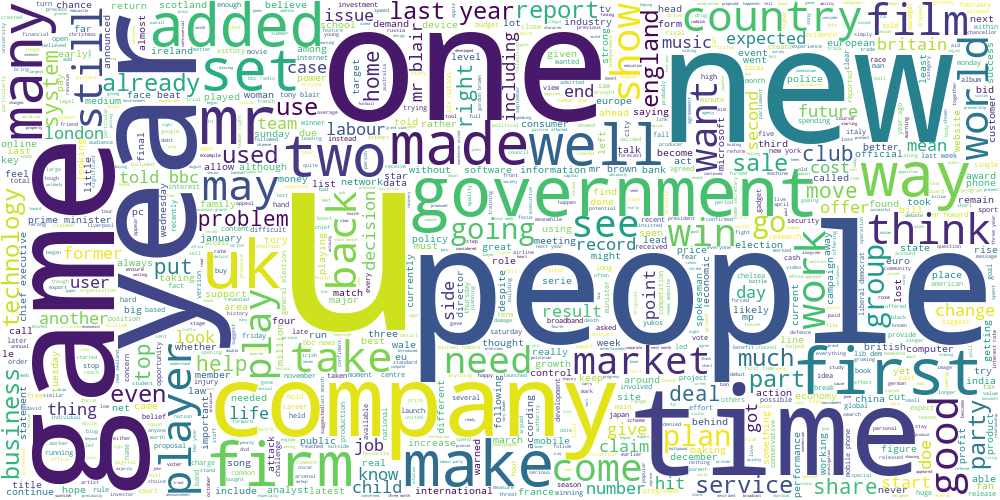

In [111]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

In [565]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.01)
X = vectorizer.fit_transform(data.text)

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans_labels = kmeans.labels_

In [143]:
labeled = data
labeled['cluster'] = kmeans_labels
clusters = labeled['cluster'].unique()
clusters

array([6, 7, 1, 0, 3, 5, 2, 4], dtype=int32)

Как видим, в каждом из кластеров получился набор слов примерно в одной тематике. Озаглавим каждый. 

### IT

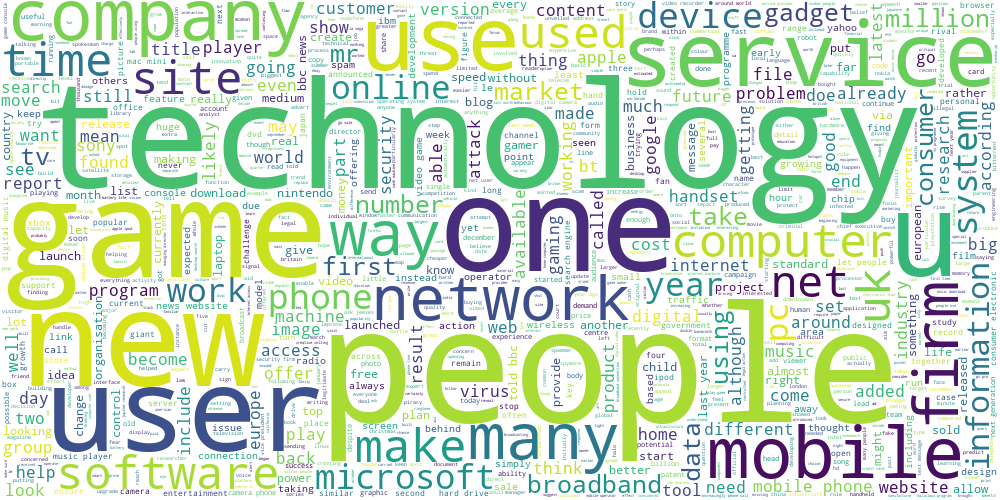

In [144]:
draw_wordcloud(labeled[labeled['cluster'] == 0].text)

### Politics

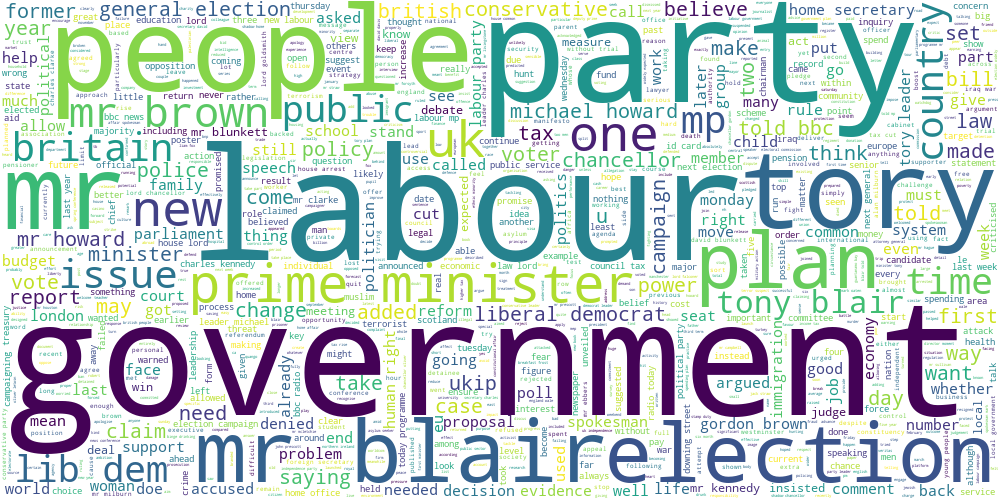

In [145]:
draw_wordcloud(labeled[labeled['cluster'] == 1].text)

### Sport

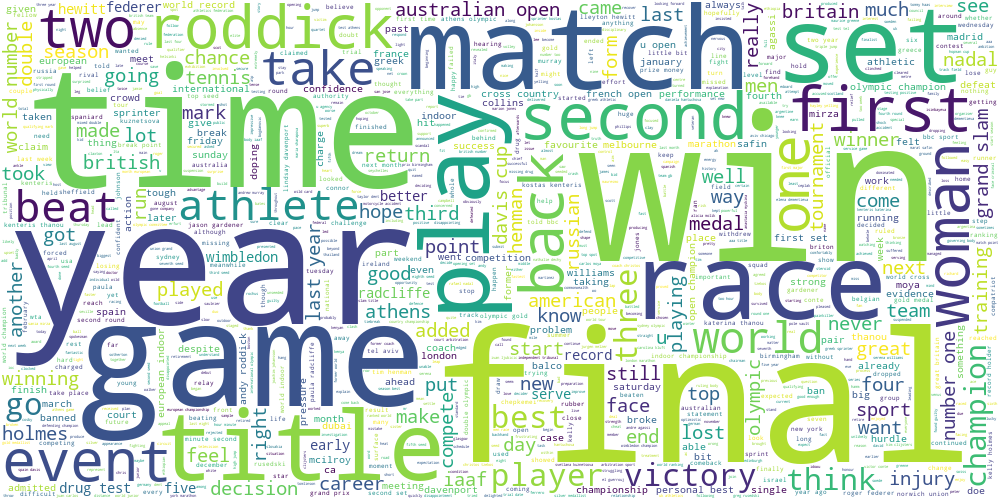

In [146]:
draw_wordcloud(labeled[labeled['cluster'] == 2].text)

### Football

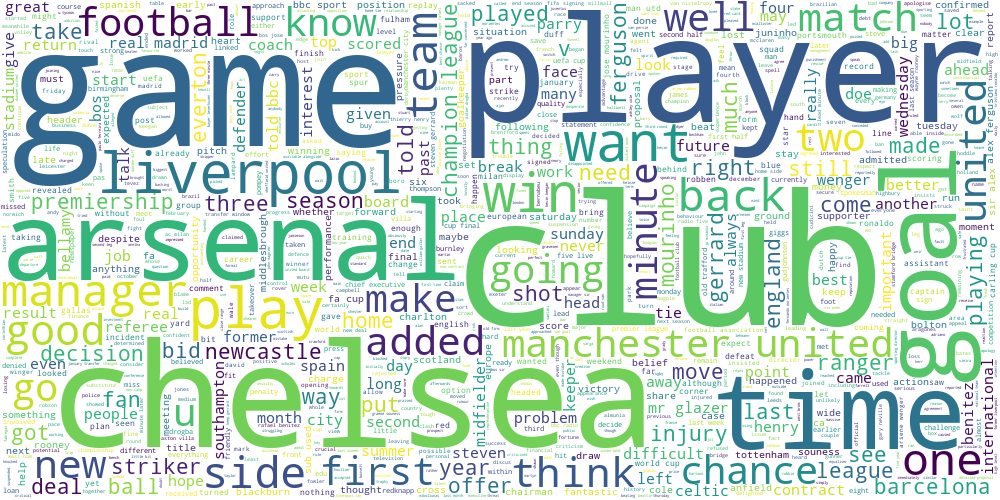

In [147]:
draw_wordcloud(labeled[labeled['cluster'] == 3].text)

### World Championship

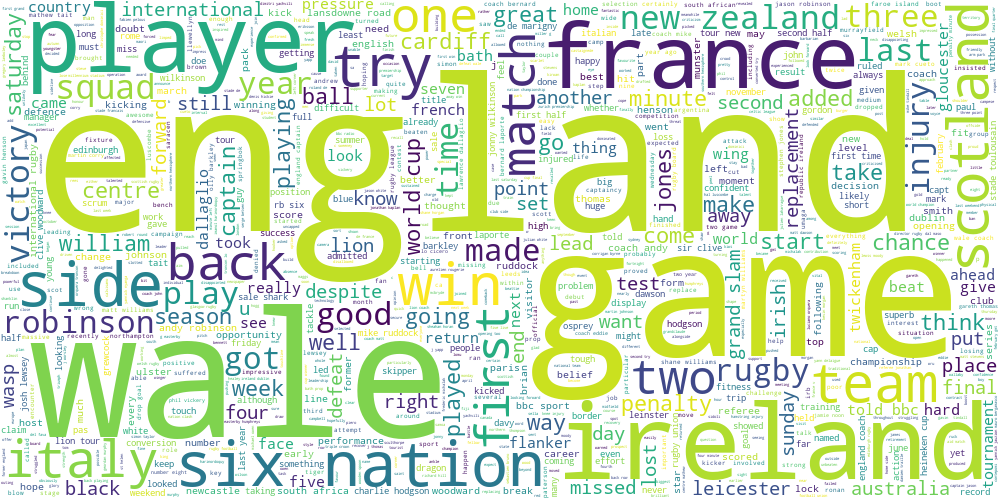

In [148]:
draw_wordcloud(labeled[labeled['cluster'] == 4].text)

### Music

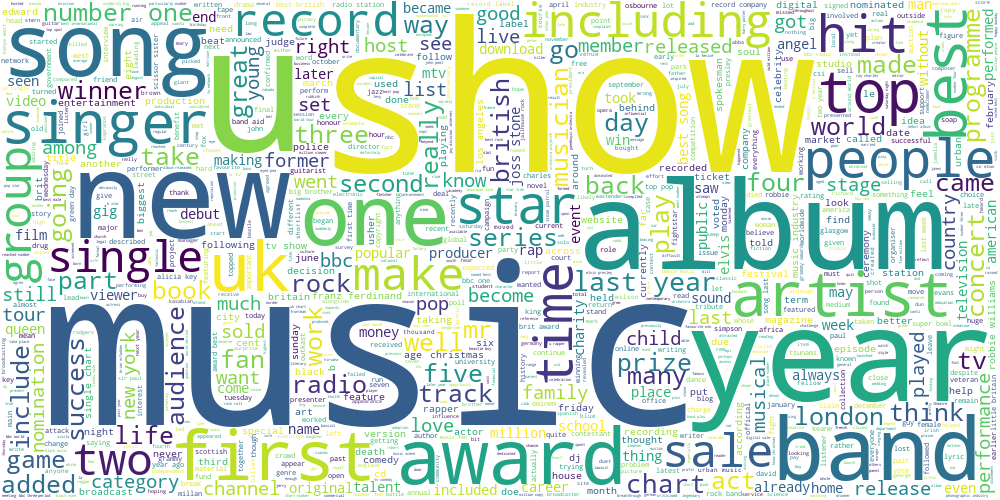

In [149]:
draw_wordcloud(labeled[labeled['cluster'] == 5].text)

### Business

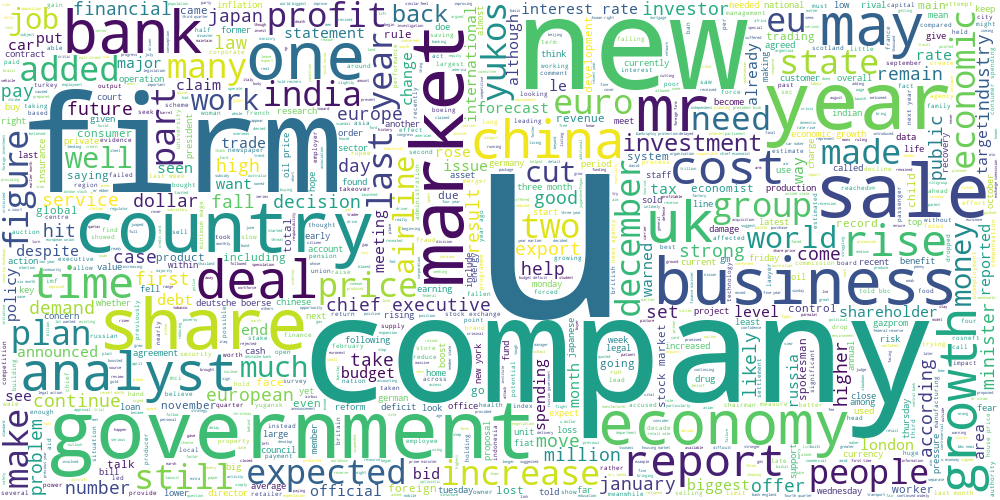

In [150]:
draw_wordcloud(labeled[labeled['cluster'] == 6].text)

### Film

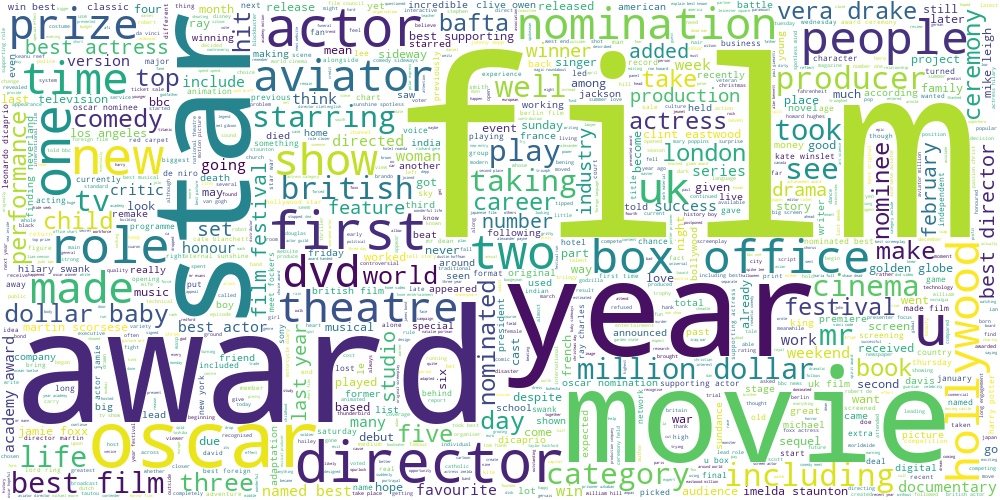

In [151]:
draw_wordcloud(labeled[labeled['cluster'] == 7].text)

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [258]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
centres = kmeans.cluster_centers_
words = vectorizer.inverse_transform(centres)
centr_words = []
for i, w in enumerate(words):
    centre = centres[i]
    centre = centre[centre != 0]
    ids = np.argsort(centre)[::-1][:5]
    
    centr_words.append(list(w[ids]))
centr_words

[['mobile', 'phone', 'people', 'technology', 'game'],
 ['mr', 'labour', 'election', 'party', 'blair'],
 ['champion', 'open', 'world', 'seed', 'olympic'],
 ['club', 'chelsea', 'game', 'arsenal', 'united'],
 ['england', 'wale', 'ireland', 'rugby', 'game'],
 ['music', 'show', 'band', 'album', 'award'],
 ['company', 'firm', 'year', 'market', 'bank'],
 ['film', 'award', 'best', 'oscar', 'actor']]

Таким образом, видно, что в кластерах слова с максимальным значением в центрах действительно совпадают с основной темой в облаках тегов.

**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [259]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

### K-Means

In [571]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans_labels = kmeans.labels_
np.unique(kmeans_labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

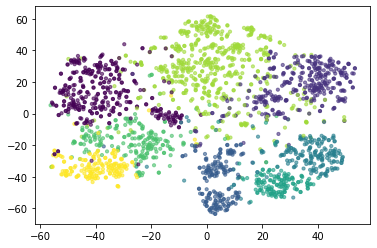

In [279]:
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmeans_labels, alpha = 0.6, s=10)

### DBSCAN

In [586]:
DBSCAN_clustering = DBSCAN(eps=0.867).fit(X)
dbscan_labels = DBSCAN_clustering.labels_
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

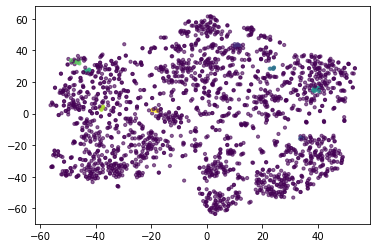

In [587]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=dbscan_labels, alpha = 0.6, s=10)

### Спектральная кластеризация

In [223]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=8, random_state=0).fit(X)
spectral_labels = clustering.labels_
np.unique(spectral_labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

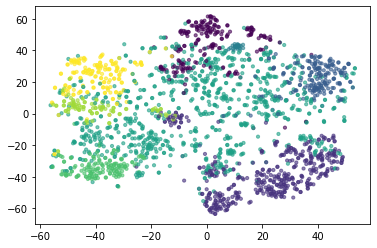

In [277]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=spectral_labels, alpha = 0.6, s=10)

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:**
Как видим, лучше всего справился K-Means, его кластеры получились самыми отделенными друг от друга, затем спектральная кластеризация, в которой некоторые кластеры пересекаются, вероятно, из-за наличия схожих тем (выше видно, что есть несколько подтем на тему спорта). Хуже всего справился DBSCAN потому что он выделил большое количество объектов как шум, вероятно, из-за низкой плотности точек, тем самым, почти не справился с задачей. 

Мы так же можем заметить, что визуализации на текстовых и географических данных почти не соотносятся, поскольку в географической мы стремились выделять более проятженные кластеры, а в текстовых кластеризация была ближе к виду окружностей (нахождении близких относительно друг друга объектов). 

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

In [575]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

countvec = CountVectorizer()
cdf = countvec.fit_transform(data.text)

lda = LatentDirichletAllocation(n_components=16, random_state=0)
lda_model = lda.fit(cdf)

Источник: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [308]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

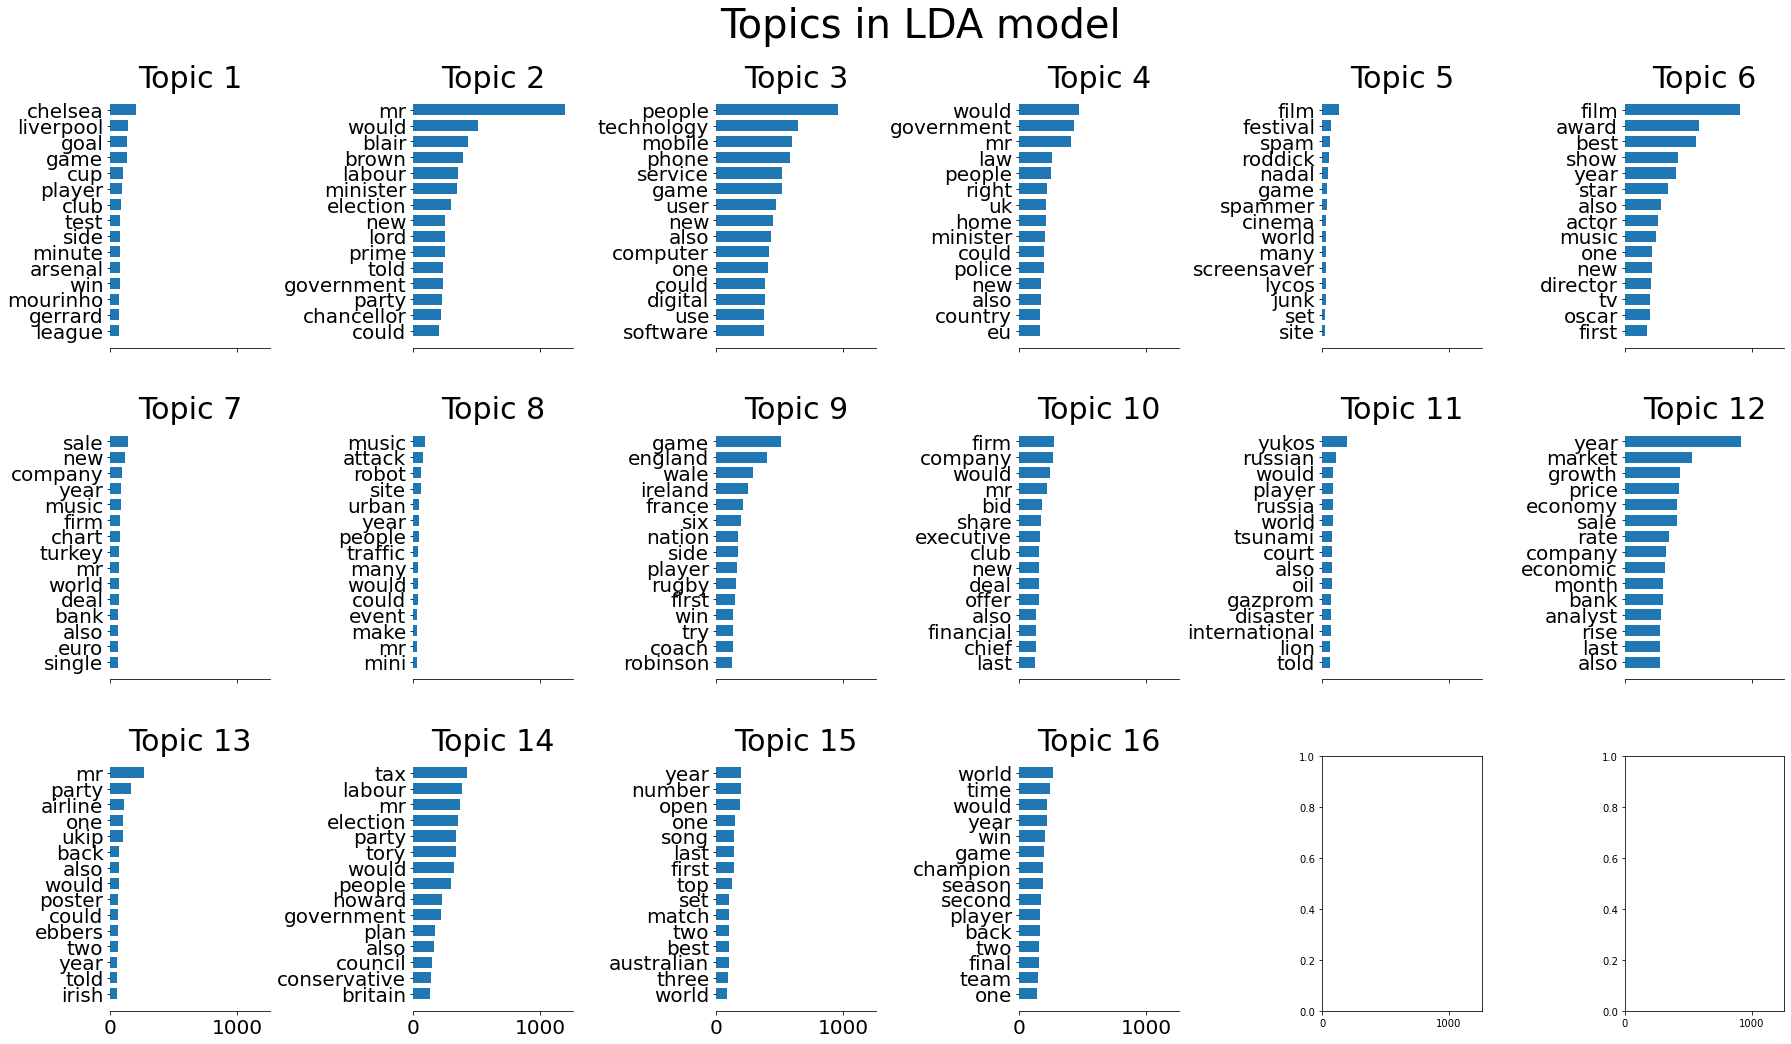

In [345]:
tf_feature_names = countvec.get_feature_names()
plot_top_words(lda_model, tf_feature_names, 15, "Topics in LDA model")

Темы стали более узкими, поскольку в них встречаются более редкие слова, но при этом четко описывающие топик. Однако с такой кодировкой изначального текста не все темы получились легко считываемыми. 

Для наиболее удачных тем сделаем облако тегов. 

Источник: https://www.kaggle.com/code/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn

In [316]:
vocab = countvec.get_feature_names()
for i, comp in enumerate(lda.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
chelsea liverpool goal game cup player club test side minute 

Topic 1: 
mr would blair brown labour minister election new lord prime 

Topic 2: 
people technology mobile phone service game user new also computer 

Topic 3: 
would government mr law people right uk home minister could 

Topic 4: 
film festival spam roddick nadal game spammer cinema world many 

Topic 5: 
film award best show year star also actor music one 

Topic 6: 
sale new company year music firm chart turkey mr world 

Topic 7: 
music attack robot site urban year people traffic many would 

Topic 8: 
game england wale ireland france six nation side player rugby 

Topic 9: 
firm company would mr bid share executive club new deal 

Topic 10: 
yukos russian would player russia world tsunami court also oil 

Topic 11: 
year market growth price economy sale rate company economic month 

Topic 12: 
mr party airline one ukip back also would poster could 

Topic 13: 
tax labour mr election party tory would people 

In [322]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
    imp_words_topic=""
    comp=lda.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(background_color='white', width=600, height=400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

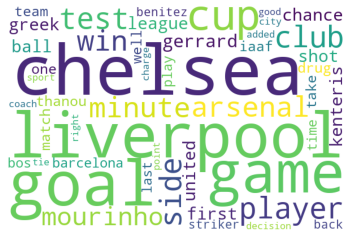

In [323]:
draw_word_cloud(0)

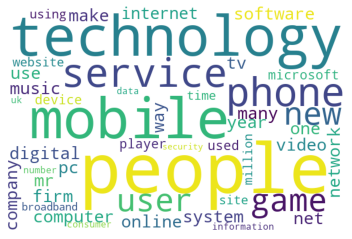

In [324]:
draw_word_cloud(2)

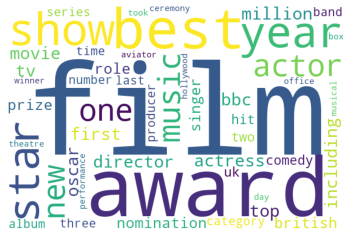

In [325]:
draw_word_cloud(5)

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

### tf-idf + logreg

In [407]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data.text, data.category, test_size = 0.3)

vectorizer = TfidfVectorizer(min_df = 0.01)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [386]:
logreg = LogisticRegression(random_state=0).fit(X_train_tfidf, y_train)
y_pred_train_logreg = logreg.predict(X_train_tfidf)
print(f'Accuracy on train data with logreg: {accuracy_score(y_train, y_pred_train_logreg)}')

y_pred_test_logreg = logreg.predict(X_test_tfidf)
print(f'Accuracy on test data with logreg: {accuracy_score(y_test, y_pred_test_logreg)}')

Accuracy on train data with logreg: 0.993577392421323
Accuracy on test data with logreg: 0.9700598802395209


### tf-idf + kmeans + logreg

In [396]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X_train_tfidf)
X_train_dist = kmeans.transform(X_train_tfidf)
X_test_dist = kmeans.transform(X_test_tfidf)

In [397]:
logreg2 = LogisticRegression(random_state=0).fit(X_train_dist, y_train)
y_pred_train_logreg_kmeans = logreg2.predict(X_train_dist)
print(f'Accuracy on train data with KMeans and logreg: {accuracy_score(y_train, y_pred_train_logreg_kmeans)}')

y_pred_test_logreg_kmeans = logreg2.predict(X_test_dist)
print(f'Accuracy on test data with KMeans and logreg: {accuracy_score(y_test, y_pred_test_logreg_kmeans)}')

Accuracy on train data with KMeans and logreg: 0.867694283879255
Accuracy on test data with KMeans and logreg: 0.8532934131736527


/Users/Arina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Latent Dirichlet + logreg

In [403]:
countvec = CountVectorizer()

X_train_cdf = countvec.fit_transform(X_train)
X_test_cdf = countvec.transform(X_test)

In [399]:
lda = LatentDirichletAllocation(n_components=16, random_state=0)
X_train_lda = lda.fit_transform(X_train_cdf)
X_test_lda = lda.transform(X_test_cdf)

In [401]:
logreg3 = LogisticRegression(random_state=0).fit(X_train_lda, y_train)
y_pred_train_logreg_probs = logreg3.predict(X_train_lda)
print(f'Accuracy on train data with LDA and logreg: {accuracy_score(y_train, y_pred_train_logreg_probs)}')

y_pred_test_logreg_probs = logreg3.predict(X_test_lda)
print(f'Accuracy on test data with LDA and logreg: {accuracy_score(y_test, y_pred_test_logreg_probs)}')

Accuracy on train data with LDA and logreg: 0.8522800256904303
Accuracy on test data with LDA and logreg: 0.9341317365269461


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:**
Лучшее качество получилось у логистической регрессии на  tf-idf признаках, поскольку при такой модели мы не агрегируем данные и не создаем дополнительные представления для них, в процессе которых может смещаться значение данных. 

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [411]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
X_train2, X_val, y_train2, y_val = train_test_split(data.text, data.category, test_size=0.3, random_state=0)

X_train_razm, X_train_nerazm, y_train_razm, y_train_nerazm = train_test_split(X_train2, y_train2, test_size=0.17, random_state=0) 

### tf-idf + logreg

In [427]:
vectorizer = TfidfVectorizer(min_df = 0.01)
X_train2_tfidf = vectorizer.fit_transform(X_train2)

X_train_razm_tfidf = vectorizer.transform(X_train_razm)
X_val_tfidf = vectorizer.transform(X_val)

In [428]:
logreg = LogisticRegression(random_state=0).fit(X_train_razm_tfidf, y_train_razm)
y_pred_val_logreg = logreg.predict(X_val_tfidf)
print(f'Accuracy on val data with logreg: {accuracy_score(y_val, y_pred_val_logreg)}')

Accuracy on train data with logreg: 0.9730538922155688


In [430]:
X_test_tfidf = vectorizer.transform(X_test)
y_pred_test_logreg = logreg.predict(X_test_tfidf)
print(f'Accuracy on test data with logreg: {accuracy_score(y_test, y_pred_test_logreg)}')

Accuracy on test data with logreg: 0.9775449101796407


### tf-idf + kmeans + logreg

In [486]:
kmeans = KMeans(n_clusters=1000, random_state=0).fit(X_train2_tfidf)

X_train_razm_dist = kmeans.transform(X_train_razm_tfidf)
X_val_dist = kmeans.transform(X_val_tfidf)

In [487]:
logreg2 = LogisticRegression(random_state=0).fit(X_train_razm_dist, y_train_razm)
y_pred_train_logreg_kmeans = logreg2.predict(X_val_dist)
print(f'Accuracy on val data with KMeans and logreg: {accuracy_score(y_val, y_pred_train_logreg_kmeans)}')

Accuracy on val data with KMeans and logreg: 0.9760479041916168


/Users/Arina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [488]:
X_test_dist = kmeans.transform(X_test_tfidf)
y_pred_test_logreg_kmeans = logreg2.predict(X_test_dist)
print(f'Accuracy on test data with KMeans and logreg: {accuracy_score(y_test, y_pred_test_logreg_kmeans)}')

Accuracy on test data with KMeans and logreg: 0.9820359281437125


### Latent Dirichlet + logreg

In [ ]:
vectorizer = TfidfVectorizer(min_df = 0.01)
X_train2_tfidf = vectorizer.fit_transform(X_train2)

X_train_razm_tfidf = vectorizer.transform(X_train_razm)
X_val_tfidf = vectorizer.transform(X_val)

In [489]:
countvec = CountVectorizer()

X_train2_cdf = countvec.fit_transform(X_train2)

X_train_razm_cdf = countvec.transform(X_train_razm)
X_val_cdf = countvec.transform(X_val)

In [513]:
lda = LatentDirichletAllocation(n_components=100, random_state=0).fit(X_train2_cdf)

X_train_razm_lda = lda.transform(X_train_razm_cdf)
X_val_lda = lda.transform(X_val_cdf)

In [514]:
logreg3 = LogisticRegression(random_state=0).fit(X_train_razm_lda, y_train_razm)
y_pred_train_logreg_kmeans = logreg3.predict(X_val_lda)
print(f'Accuracy on val data with LDA and logreg: {accuracy_score(y_val, y_pred_train_logreg_kmeans)}')

Accuracy on val data with LDA and logreg: 0.9401197604790419


In [515]:
X_test_cdf = countvec.transform(X_test)
X_test_lda = lda.transform(X_test_cdf)
y_pred_test_logreg_probs = logreg3.predict(X_test_lda)
print(f'Accuracy on test data with LDA and logreg: {accuracy_score(y_test, y_pred_test_logreg_probs)}')

Accuracy on test data with LDA and logreg: 0.875748502994012


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:**
После подбора гиперпараметров можно заметить, что лучшее качество получилось у K-Means, поскольку теперь мы не стали делить данные на большие кластеры, а позволили создать мелкие группы (большое количество компонент в гиперпараметре), что улучшило качество модели. 

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

### tf-idf + logreg

In [548]:
y_train_self = y_train2
y_train_self[X_train_nerazm.index] = -1

In [549]:
from sklearn.semi_supervised import SelfTrainingClassifier

logreg = LogisticRegression(random_state=0)
self_training_model = SelfTrainingClassifier(logreg).fit(X_train2_tfidf, y_train_self)
y_pred = self_training_model.predict(X_val_tfidf)
print(f'Accuracy on val data with logreg: {accuracy_score(y_val, y_pred)}')

Accuracy on val data with logreg: 0.9730538922155688


In [550]:
y_pred_test_logreg = self_training_model.predict(X_test_tfidf)
print(f'Accuracy on test data with logreg: {accuracy_score(y_test, y_pred_test_logreg)}')

Accuracy on test data with logreg: 0.9775449101796407


### tf-idf + kmeans + logreg

In [552]:
X_train2_dist = kmeans.transform(X_train2_tfidf)

In [553]:
logreg2 = LogisticRegression(random_state=0)
self_training_model = SelfTrainingClassifier(logreg2).fit(X_train2_dist, y_train_self)
y_pred_kmeans = self_training_model.predict(X_val_dist)
print(f'Accuracy on val data with KMeans and logreg: {accuracy_score(y_val, y_pred_kmeans)}')

/Users/Arina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Arina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Accuracy on val data with KMeans and logreg: 0.9730538922155688


/Users/Arina/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [554]:
y_pred_test_logreg_kmeans = self_training_model.predict(X_test_dist)
print(f'Accuracy on test data with KMeans and logreg: {accuracy_score(y_test, y_pred_test_logreg_kmeans)}')

Accuracy on test data with KMeans and logreg: 0.9820359281437125


### Latent Dirichlet + logreg

In [ ]:
vectorizer = TfidfVectorizer(min_df = 0.01)
X_train2_tfidf = vectorizer.fit_transform(X_train2)

X_train_razm_tfidf = vectorizer.transform(X_train_razm)
X_val_tfidf = vectorizer.transform(X_val)

In [489]:
countvec = CountVectorizer()

X_train2_cdf = countvec.fit_transform(X_train2)

X_train_razm_cdf = countvec.transform(X_train_razm)
X_val_cdf = countvec.transform(X_val)

In [513]:
lda = LatentDirichletAllocation(n_components=100, random_state=0).fit(X_train2_cdf)

X_train_razm_lda = lda.transform(X_train_razm_cdf)
X_val_lda = lda.transform(X_val_cdf)

In [555]:
X_train2_lda = lda.transform(X_train2_cdf)

In [556]:
logreg3 = LogisticRegression(random_state=0)
self_training_model = SelfTrainingClassifier(logreg3).fit(X_train2_lda, y_train_self)
y_pred_lda = self_training_model.predict(X_val_lda)
print(f'Accuracy on val data with LDA and logreg: {accuracy_score(y_val, y_pred_lda)}')

Accuracy on val data with LDA and logreg: 0.9401197604790419


In [557]:
y_pred_test_logreg_probs = self_training_model.predict(X_test_lda)
print(f'Accuracy on test data with LDA and logreg: {accuracy_score(y_test, y_pred_test_logreg_probs)}')

Accuracy on test data with LDA and logreg: 0.874251497005988


Таким образом, качество моделей практически не изменилось, поскольку semi-supervised алгоритмы могут работать хорошо, когда у нас очень небольшое количество помеченных точек и большое количество немаркированных точек, однако в нашей ситуации большинство точек имеют лейблы. 

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [577]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.01)
X = vectorizer.fit_transform(data.text)

In [580]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans_labels = kmeans.labels_
data['cluster_kmeans'] = kmeans_labels

array([6, 7, 1, 0, 3, 5, 2, 4], dtype=int32)

In [582]:
clustering = SpectralClustering(n_clusters=8, random_state=0).fit(X)
spectral_labels = clustering.labels_
data['cluster_graph'] = spectral_labels

In [583]:
DBSCAN_clustering = DBSCAN(eps=0.867).fit(X)
dbscan_labels = DBSCAN_clustering.labels_
data['cluster_dbscan'] = dbscan_labels

In [584]:
data

category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  \
0      Quarterly profits at US media giant TimeWarne...   
1      The dollar has hit its highest level against ...   
2      The owners of embattled Russian oil giant Yuk...   
3      British Airways has blamed high fuel prices f...   
4      Shares in UK drinks and food firm Allied Dome...   
...                                                 ...   
2220   BT is introducing two initiatives to help bea...   
2221   Computer users across the world continue to i...   
2222   A new European directive could put software w...   
2223   The man making sure US computer networks are ...   
2224   Online role playing games are time-consuming,...   

                                               raw_text  \
0     Ad sales boost Time Warner profit Quarterly pr...   
1     Dollar gains on Greenspan speech The dollar ha...   
2     Yukos unit buyer faces loan claim The owners o...   
3     High fuel prices hit BA's profits British Airw...   
4     Pernod takeover talk lifts Domecq Shares in UK...   
...                                                 ...   
2220  BT program to beat dialler scams BT is introdu...   
2221  Spam e-mails tempt net shoppers Computer users...   
2222  Be careful how you code A new European directi...   
2223  US cyber security chief resigns The man making...   
2224  Losing yourself in online gaming Online role p...   

                                                   text  cluster  \
0     ad sale boost time warner profit quarterly pro...        6   
1     dollar gain greenspan speech dollar hit highes...        6   
2     yukos unit buyer face loan claim owner embattl...        6   
3     high fuel price hit ba profit british airway b...        6   
4     pernod takeover talk lift domecq share uk drin...        6   
...                                                 ...      ...   
2220  bt program beat dialler scam bt introducing tw...        0   
2221  spam tempt net shopper computer user across wo...        0   
2222  careful code new european directive could put ...        0   
2223  u cyber security chief resigns man making sure...        0   
2224  losing online gaming online role playing game ...        0   

      cluster_kmeans  cluster_graph  cluster_dbscan  
0                  6              0              -1  
1                  6              0              -1  
2                  6              3               0  
3                  6              0              -1  
4                  6              4              -1  
...              ...            ...             ...  
2220               0              7              -1  
2221               0              7              -1  
2222               0              7              -1  
2223               0              7              -1  
2224               0              1              -1  

[2225 rows x 10 columns]

In [623]:
gold_standard = {}
kmeans_dict = {}
dbscan_dict = {}
graph_dict = {}
for i in range(len(data)-1):
    gold_standard[data.index[i]] = set([data['category'][i]])
    kmeans_dict[data.index[i]] = set([data['cluster_kmeans'][i]])
    dbscan_dict[data.index[i]] = set([data['cluster_dbscan'][i]])
    graph_dict[data.index[i]] = set([data['cluster_graph'][i]])

In [624]:
import bcubed

precision = bcubed.precision(gold_standard, kmeans_dict)
recall = bcubed.recall(gold_standard, kmeans_dict)
fscore = bcubed.fscore(precision, recall)
print(f'K-Means precision: {precision}, recall: {recall}, fscore: {fscore}')

K-Means precision: 0.6421708365484055, recall: 0.8698006211706997, fscore: 0.7388507100129142


In [625]:
precision = bcubed.precision(gold_standard, dbscan_dict)
recall = bcubed.recall(gold_standard, dbscan_dict)
fscore = bcubed.fscore(precision, recall)
print(f'DBSCAN precision: {precision}, recall: {recall}, fscore: {fscore}')

DBSCAN precision: 0.949530229603875, recall: 0.22418450281326185, fscore: 0.3627286197413995


In [626]:
precision = bcubed.precision(gold_standard, graph_dict)
recall = bcubed.recall(gold_standard, graph_dict)
fscore = bcubed.fscore(precision, recall)
print(f'SpectralClustering precision: {precision}, recall: {recall}, fscore: {fscore}')

SpectralClustering precision: 0.5010996214946283, recall: 0.6482138649123352, fscore: 0.5652412961247111


Как видим, подсчет метрики подтвердил визуализацию из предыдущего задания и лучше всего с задачей кластеризации текста справляется K-Means, затем спектральная кластеризация и хуже всего задачу выполняет DBSCAN.

**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

1. Возьмите какие-нибудь данные высокой размерности
2. найдите какой-нибудь метод обучения эмбеддингов
3. примените его
4. кластеризуйте полученные представления
5. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации

In [7]:
import pandas as pd

In [8]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
twits = pd.read_csv('Corona_NLP_train.csv', encoding="latin-1")
twits

UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1      advice Talk to your neighbours family to excha...            Positive  
2      Coronavirus Australia: Woolworths to give elde...            Positive  
3      My food stock is not the only one which is emp...            Positive  
4      Me, ready to go at supermarket during the #COV...  Extremely Negative  
...                                                  ...                 ...  
41152  Airline pilots offering to stock supermarket s...             Neutral  
41153  Response to complaint not provided citing COVI...  Extremely Negative  
41154  You know itÂs getting tough when @KameronWild...            Positive  
41155  Is it wrong that the smell of hand sanitizer i...             Neutral  
41156  @TartiiCat Well new/used Rift S are going for ...            Negative  

[41157 rows x 6 columns]

In [632]:
twits.OriginalTweet[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [1]:
from langchain.embeddings import HuggingFaceEmbeddings

In [4]:
embeddings = HuggingFaceEmbeddings()

In [9]:
query_result = embeddings.embed_query(twits.OriginalTweet)

KeyboardInterrupt: 

In [ ]:
query_result

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.01)
X = vectorizer.fit_transform(data.text)

**Задание 7 (1 балл)**. Наконец, ставший ежегодной традицией социализационный бонус. Мы поощряем не только предметное, но и духовное развитие. Поэтому, чтобы заработать балл за это задание, сходите на какую-нибудь выставку или в музей, напишите небольшой отчетик о ваших впечатлениях и добавьте фотопруфы в ноутбук при сдаче. Можете объединиться с одногруппниками/однокурсниками, а также пригласить ассистентов/преподавателей, они тоже будут рады выбраться куда-нибудь. Для вдохновения приведем ссылку на актуальные выставки [новой](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab) и [старой Третьяковки](https://www.youtube.com/watch?v=xm3YgoEiEDc) (но совсем не обязательно посещать именно их).

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻

In [10]:
pip show numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /Users/Arina/opt/anaconda3/lib/python3.9/site-packages
Requires: 
Required-by: xarray, wordcloud, triad, transformers, torchvision, torchmetrics, tifffile, tensorflow, tensorboard, tables, statsmodels, statsforecast, sktime, sentence-transformers, seaborn, scipy, scikit-learn, scikit-image, PyWavelets, pytorch-lightning, pyhdfe, pyerfa, pyarrow, pmdarima, plotly-resampler, patsy, pandas, opt-einsum, numexpr, numba, mkl-random, mkl-fft, matplotlib, linearmodels, la

In [1]:
import numpy as np

In [2]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)

In [3]:
x

array([0. , 0.5, 1. ])

In [4]:
xv

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])